In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Wed Jul 29 21:54:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 52%   84C    P2   229W / 250W |   4586MiB / 11019MiB |     71%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name


##  200719  mds
folder = '29July2020_Trks_to_KDE_C__A_lossB_100_epochs_b64_3m4_nOut_100x100'
name = '29July2020_Trks_to_KDE_C_A_lossB_100_epochs_b64_3m4_nOut_100x100'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 64
# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_kde_A import collect_t2kde_data

# From model/loss.py
##from loss import Loss
from model.kde_loss_B import Loss


from model.models_kde import TracksToKDE_C as Model


from model.training_kde import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:

## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch

train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
##train_loader = collect_t2kde_data('/share/lazy/pv-finder/test_data_for_KDE_learning_BastilleDay20.h5',
                            batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                           device=device,
                           slice = slice(None,18000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

Loading data...
len(X) =  20000
len(Xlist) =  1
Loaded /share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5 in 7.936 s
outer loop X.shape =  (20000, 6, 600)
Constructing 18000 event dataset took 3.233 s
x_t.shape =  torch.Size([18000, 6, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  6
x_t.shape =  torch.Size([18000, 6, 600])
Loading data...
len(X) =  20000
len(Xlist) =  1
Loaded /share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5 in 7.367 s
outer loop X.shape =  (20000, 6, 600)
Constructing 2000 event dataset took 0.04388 s
x_t.shape =  torch.Size([2000, 6, 600])
x_t.shape[0] =  2000
x_t.shape[1] =  6
x_t.shape =  torch.Size([2000, 6, 600])


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 100
nOut2 = 100
model = Model(nOut1,nOut2)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
loss = Loss(epsilon=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=6, out_features=100, bias=True)
ct, child =  1    Linear(in_features=100, out_features=100, bias=True)
ct, child =  2    Linear(in_features=100, out_features=4000, bias=True)


In [11]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

print(" \n","  for pretrained_dict")
index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  ML/29July2020_Trks_to_KDE_C__A_lossB_100_epochs_b64_3m4_nOut_100x100
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
 
   for pretrained_dict
pretrained_dict iterated


In [13]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [14]:
model = model.to(device)

with torch.no_grad():
    counter = 0
    event = 0
    print("train_loader = ",train_loader)
    for inputs, labels in train_loader:
##        print("counter = ",counter)
##        print("inputs = ",inputs)
        print("inputs.shape = ",inputs.shape)
        if inputs.device != device:
            inputs, labels = inputs.to(device), labels.to(device)
            
        outputs = model(inputs)
##        print("outputs.shape = ",outputs.shape)
        nEvts = outputs.shape[0]
        for iEvt in range(nEvts):
            y_pred = outputs[iEvt,:]
            y_pred = y_pred.cpu().numpy()
            
            event = event +1
##            print("event = ",event)
            if (event<5):
                plt.figure()
                plt.plot(y_pred[0:50])
                plt.show()
                
##                print("  point AA ")
                features = inputs[iEvt,:]
                features = features[np.newaxis,:,:]
                
                
                print("features.shape = ",features.shape)
                
                output_A = model(features)
                y_prime = output_A[0,:]
                y_prime = y_prime.cpu().numpy()
                plt.figure()
                plt.plot(y_prime[0:50], color="r")
                plt.show()
                
            

##        print("nEvts = ",nEvts)
        
        counter = counter+1
        
        
        

<IPython.core.display.Javascript object>


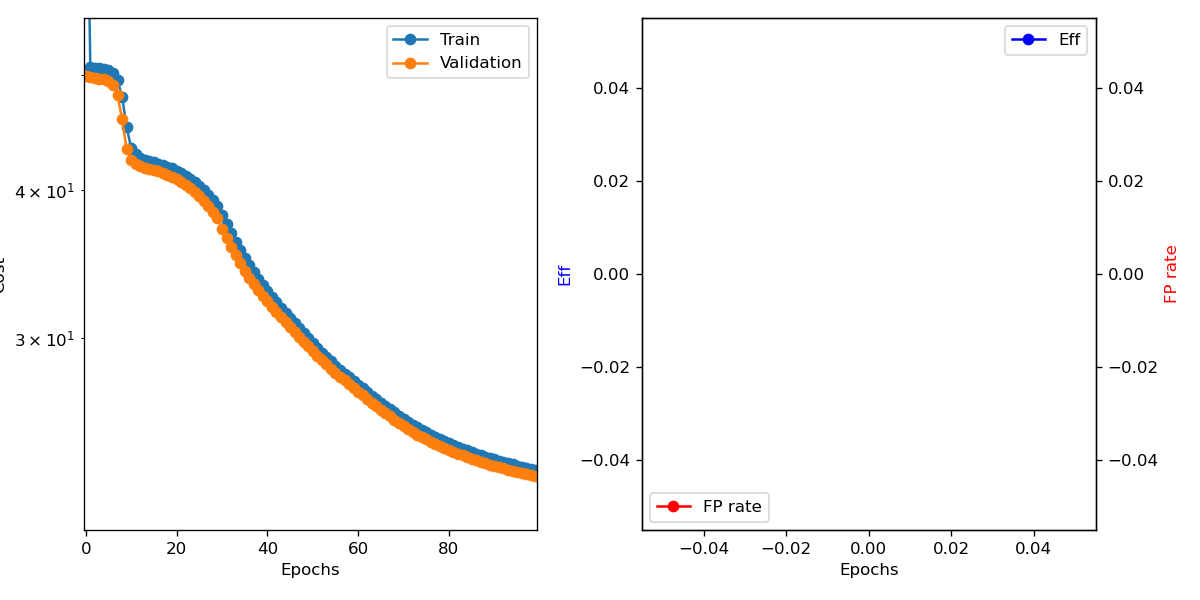

In [15]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [16]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 282, val = 32


Number of batches: train = 282, val = 32


Epoch 0: train=89.9732, val=49.8932, took 17.337 s


Epoch 1: train=50.7587, val=49.7566, took 16.187 s


Epoch 2: train=50.674, val=49.6933, took 16.206 s


Epoch 3: train=50.6182, val=49.6406, took 16.237 s


Epoch 4: train=50.5512, val=49.5594, took 16.25 s


Epoch 5: train=50.4295, val=49.3929, took 16.158 s


Epoch 6: train=50.1611, val=49.0056, took 16.115 s


Epoch 7: train=49.5051, val=48.0408, took 16.215 s


Epoch 8: train=47.9181, val=45.8687, took 16.123 s


Epoch 9: train=45.1582, val=43.2661, took 15.915 s


Epoch 10: train=43.3868, val=42.3899, took 16.322 s


Epoch 11: train=42.8419, val=42.0628, took 16.236 s


Epoch 12: train=42.5745, val=41.8805, took 16.369 s


Epoch 13: train=42.4059, val=41.7516, took 16.341 s


Epoch 14: train=42.2801, val=41.6456, took 16.324 s


Epoch 15: train=42.1724, val=41.5448, took 16.233 s


Epoch 16: train=42.067, val=41.4379, took 16.401 s


Epoch 17: train=41.9541, val=41.3172, took 16.363 s


Epoch 18: train=41.8267, val=41.1767, took 16.231 s


Epoch 19: train=41.68, val=41.0124, took 16.217 s


Epoch 20: train=41.511, val=40.8227, took 16.243 s


Epoch 21: train=41.3182, val=40.6077, took 16.505 s


Epoch 22: train=41.1011, val=40.3673, took 16.286 s


Epoch 23: train=40.8587, val=40.1008, took 16.228 s


Epoch 24: train=40.5892, val=39.8069, took 16.255 s


Epoch 25: train=40.2902, val=39.4835, took 16.178 s


Epoch 26: train=39.9589, val=39.1285, took 16.183 s


Epoch 27: train=39.5927, val=38.7377, took 16.217 s


Epoch 28: train=39.1882, val=38.3067, took 16.13 s


Epoch 29: train=38.7441, val=37.8237, took 16.026 s


Epoch 30: train=38.106, val=37.0636, took 16.258 s


Epoch 31: train=37.43, val=36.4065, took 16.254 s


Epoch 32: train=36.7817, val=35.783, took 16.225 s


Epoch 33: train=36.1595, val=35.1999, took 16.337 s


Epoch 34: train=35.5745, val=34.66, took 16.265 s


Epoch 35: train=35.031, val=34.1659, took 16.227 s


Epoch 36: train=34.5284, val=33.7131, took 16.139 s


Epoch 37: train=34.063, val=33.2945, took 16.181 s


Epoch 38: train=33.6311, val=32.9045, took 16.215 s


Epoch 39: train=33.2275, val=32.5381, took 16.321 s


Epoch 40: train=32.8472, val=32.1907, took 15.971 s


Epoch 41: train=32.4854, val=31.8565, took 16.187 s


Epoch 42: train=32.1381, val=31.5369, took 16.288 s


Epoch 43: train=31.8036, val=31.2269, took 16.25 s


Epoch 44: train=31.4779, val=30.9237, took 16.207 s


Epoch 45: train=31.16, val=30.6254, took 16.141 s


Epoch 46: train=30.8485, val=30.3332, took 16.237 s


Epoch 47: train=30.5447, val=30.0475, took 16.236 s


Epoch 48: train=30.248, val=29.7675, took 16.212 s


Epoch 49: train=29.9604, val=29.4967, took 16.108 s


Epoch 50: train=29.6809, val=29.2324, took 16.206 s


Epoch 51: train=29.4096, val=28.9751, took 16.16 s


Epoch 52: train=29.1475, val=28.7253, took 16.235 s


Epoch 53: train=28.8948, val=28.4847, took 16.05 s


Epoch 54: train=28.6526, val=28.2531, took 16.257 s


Epoch 55: train=28.4199, val=28.0293, took 16.158 s


Epoch 56: train=28.1974, val=27.8151, took 16.171 s


Epoch 57: train=27.9845, val=27.6094, took 16.106 s


Epoch 58: train=27.7808, val=27.4118, took 16.188 s


Epoch 59: train=27.5849, val=27.2174, took 16.195 s


Epoch 60: train=27.3895, val=27.0205, took 16.226 s


Epoch 61: train=27.192, val=26.8225, took 16.22 s


Epoch 62: train=26.9965, val=26.6279, took 16.349 s


Epoch 63: train=26.807, val=26.4398, took 16.352 s


Epoch 64: train=26.6247, val=26.2591, took 16.319 s


Epoch 65: train=26.4499, val=26.0857, took 16.232 s


Epoch 66: train=26.2829, val=25.9199, took 16.282 s


Epoch 67: train=26.123, val=25.7615, took 16.291 s


Epoch 68: train=25.9462, val=25.5669, took 16.129 s


Epoch 69: train=25.777, val=25.4073, took 16.083 s


Epoch 70: train=25.6236, val=25.2575, took 16.11 s


Epoch 71: train=25.479, val=25.1163, took 16.108 s


Epoch 72: train=25.342, val=24.9821, took 16.151 s


Epoch 73: train=25.2116, val=24.8545, took 16.141 s


Epoch 74: train=25.0874, val=24.7336, took 16.178 s


Epoch 75: train=24.9686, val=24.6183, took 16.168 s


Epoch 76: train=24.8553, val=24.508, took 16.138 s


Epoch 77: train=24.7468, val=24.4037, took 16.105 s


Epoch 78: train=24.6429, val=24.3041, took 16.14 s


Epoch 79: train=24.5433, val=24.2086, took 16.179 s


Epoch 80: train=24.4477, val=24.1174, took 16.247 s


Epoch 81: train=24.3562, val=24.03, took 16.129 s


Epoch 82: train=24.2686, val=23.9463, took 16.445 s


Epoch 83: train=24.1844, val=23.8663, took 16.397 s


Epoch 84: train=24.1037, val=23.7892, took 16.287 s


Epoch 85: train=24.0262, val=23.7154, took 16.234 s


Epoch 86: train=23.9517, val=23.6442, took 16.229 s


Epoch 87: train=23.8803, val=23.5762, took 16.293 s


Epoch 88: train=23.8116, val=23.5106, took 16.262 s


Epoch 89: train=23.7454, val=23.4478, took 16.134 s


Epoch 90: train=23.6819, val=23.3874, took 16.295 s


Epoch 91: train=23.6208, val=23.329, took 16.438 s


Epoch 92: train=23.5618, val=23.2735, took 16.414 s


Epoch 93: train=23.5055, val=23.2201, took 16.388 s


Epoch 94: train=23.4512, val=23.1685, took 16.169 s


Epoch 95: train=23.3989, val=23.1191, took 16.445 s


Epoch 96: train=23.3487, val=23.0716, took 16.339 s


Epoch 97: train=23.3004, val=23.0259, took 16.338 s


Epoch 98: train=23.2537, val=22.9819, took 16.399 s


Epoch 99: train=23.2088, val=22.939, took 16.429 s



Go ahead and save the final model (even though it was also saved above):

In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


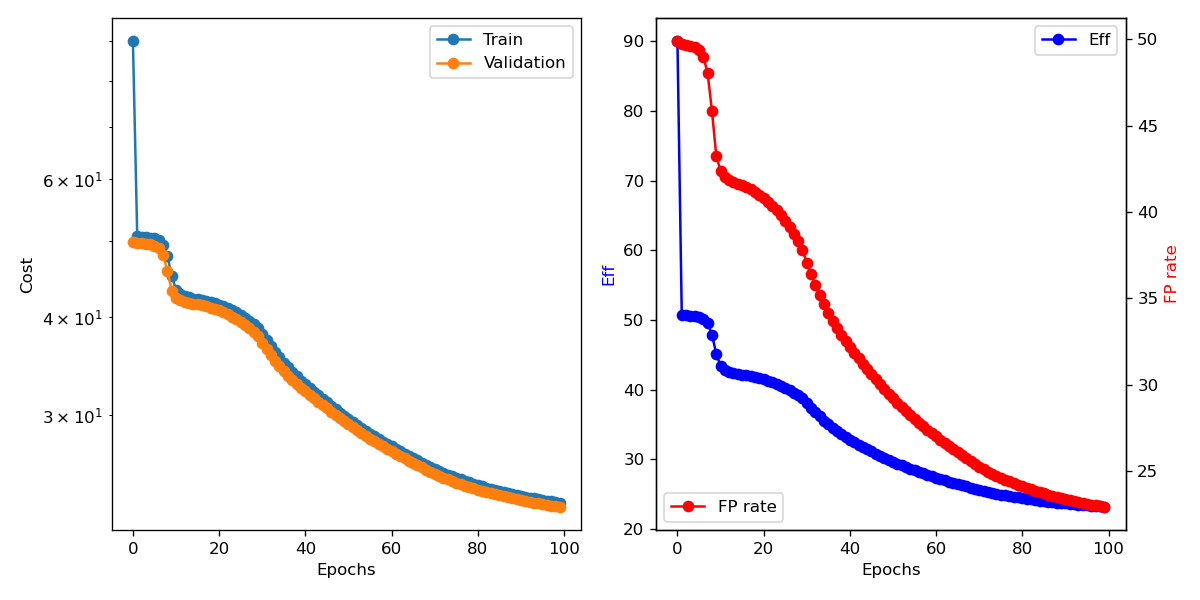

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))